# Feature Engineering for Package Risk Scoring

This notebook transforms raw package metadata into features for ML models.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## 1. Load Data

In [2]:
# Load the collected data
data_path = Path("data/pypi_packages.csv")
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} packages")
df.head()

Loaded 100 packages


,name,version,days_since_creation,version_count,has_homepage,has_repository,description_length,summary_length,author,license,requires_python,classifiers_count,is_malicious
0,requests,2.32.5,5452,157,True,True,2927,23,Kenneth Reitz,Apache-2.0,>=3.9,19,0
1,numpy,2.4.1,6987,141,False,False,4199,49,Travis E. Oliphant et al.,NaN,>=3.11,19,0
2,pandas,2.3.3,5867,111,False,False,11533,71,NaN,BSD 3-Clause License\n \n Copy...,>=3.9,16,0
3,matplotlib,3.10.8,7314,137,False,False,3741,23,"John D. Hunter, Michael Droettboom",License agreement for matplotlib versions 1.3....,>=3.10,13,0
4,scipy,1.17.0,5654,103,False,False,3720,57,NaN,"Copyright (c) 2001-2002 Enthought, Inc. 2003, ...",>=3.11,18,0


In [3]:
# Check data types and missing values
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())


Data Types:
name                   object
version                object
days_since_creation     int64
version_count           int64
has_homepage             bool
has_repository           bool
description_length      int64
summary_length          int64
author                 object
license                object
requires_python        object
classifiers_count       int64
is_malicious            int64
dtype: object

Missing Values:
name                    0
version                 0
days_since_creation     0
version_count           0
has_homepage            0
has_repository          0
description_length      0
summary_length          0
author                 35
license                74
requires_python        51
classifiers_count       0
is_malicious            0
dtype: int64


## 2. Feature Engineering

In [4]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create engineered features for ML model.
    """
    df = df.copy()
    
    # Convert boolean columns to int
    df["has_homepage"] = df["has_homepage"].astype(int)
    df["has_repository"] = df["has_repository"].astype(int)
    
    # Create age category
    df["is_very_new"] = (df["days_since_creation"] < 30).astype(int)
    df["is_established"] = (df["days_since_creation"] > 365).astype(int)
    
    # Version maturity
    df["is_few_versions"] = (df["version_count"] <= 3).astype(int)
    
    # Documentation score (combination of description and summary)
    df["doc_score"] = (df["description_length"] + df["summary_length"]) / 1000
    df["doc_score"] = df["doc_score"].clip(upper=1.0)  # Normalize to 0-1
    
    # Has proper metadata
    df["has_license"] = (df["license"].notna() & (df["license"] != "")).astype(int)
    
    # Credibility score (composite)
    df["credibility_score"] = (
        df["has_homepage"].astype(int) + 
        df["has_repository"].astype(int) + 
        df["has_license"] +
        (df["classifiers_count"] > 0).astype(int)
    ) / 4.0
    
    return df

df_features = engineer_features(df)
print("Engineered features:")
print(df_features.columns.tolist())

Engineered features:
['name', 'version', 'days_since_creation', 'version_count', 'has_homepage', 'has_repository', 'description_length', 'summary_length', 'author', 'license', 'requires_python', 'classifiers_count', 'is_malicious', 'is_very_new', 'is_established', 'is_few_versions', 'doc_score', 'has_license', 'credibility_score']


## 3. Exploratory Data Analysis

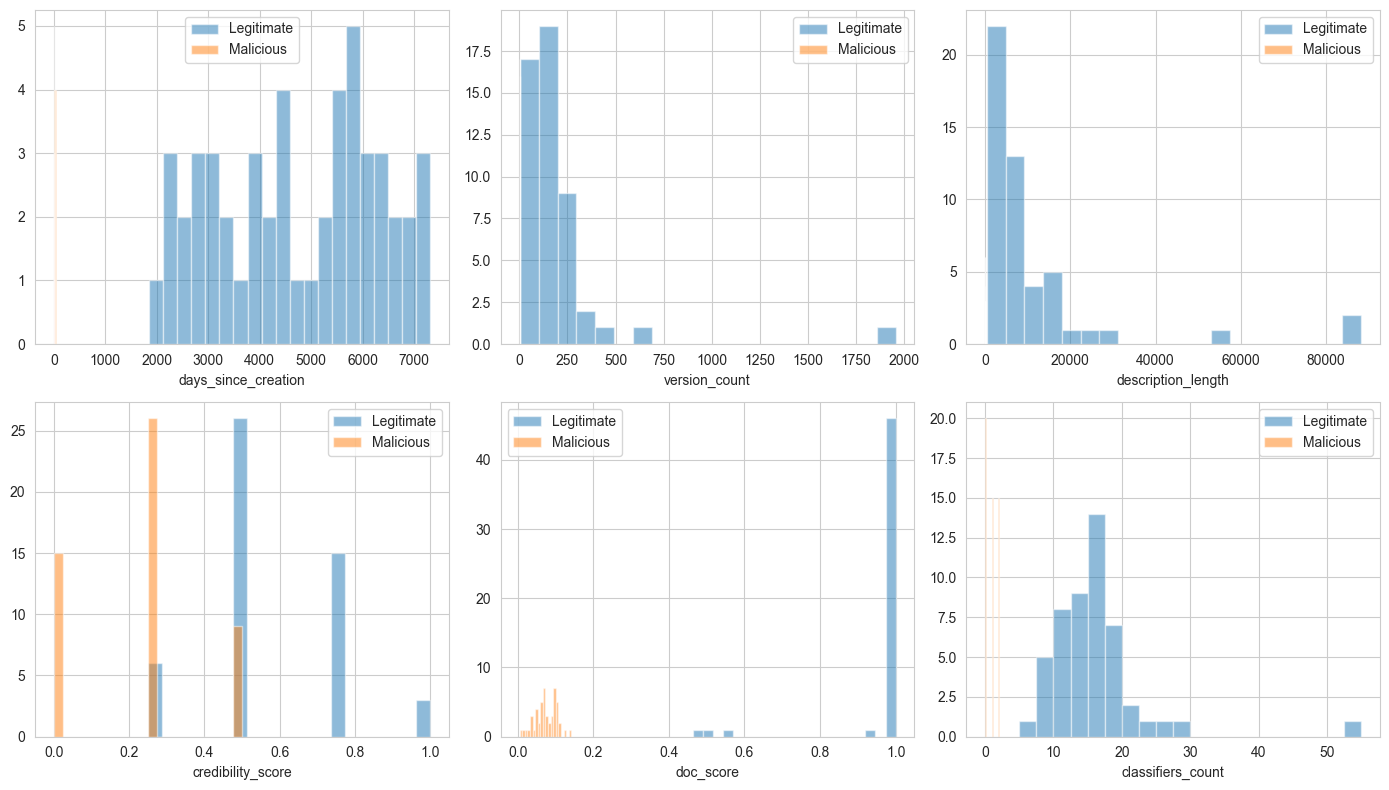

In [5]:
# Compare feature distributions between malicious and legitimate packages
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

features_to_plot = [
    "days_since_creation", "version_count", "description_length",
    "credibility_score", "doc_score", "classifiers_count"
]

for ax, feature in zip(axes.flat, features_to_plot):
    for label, group in df_features.groupby("is_malicious"):
        label_name = "Malicious" if label == 1 else "Legitimate"
        ax.hist(group[feature], alpha=0.5, label=label_name, bins=20)
    ax.set_xlabel(feature)
    ax.legend()

plt.tight_layout()
plt.savefig("data/feature_distributions.png", dpi=150)
plt.show()

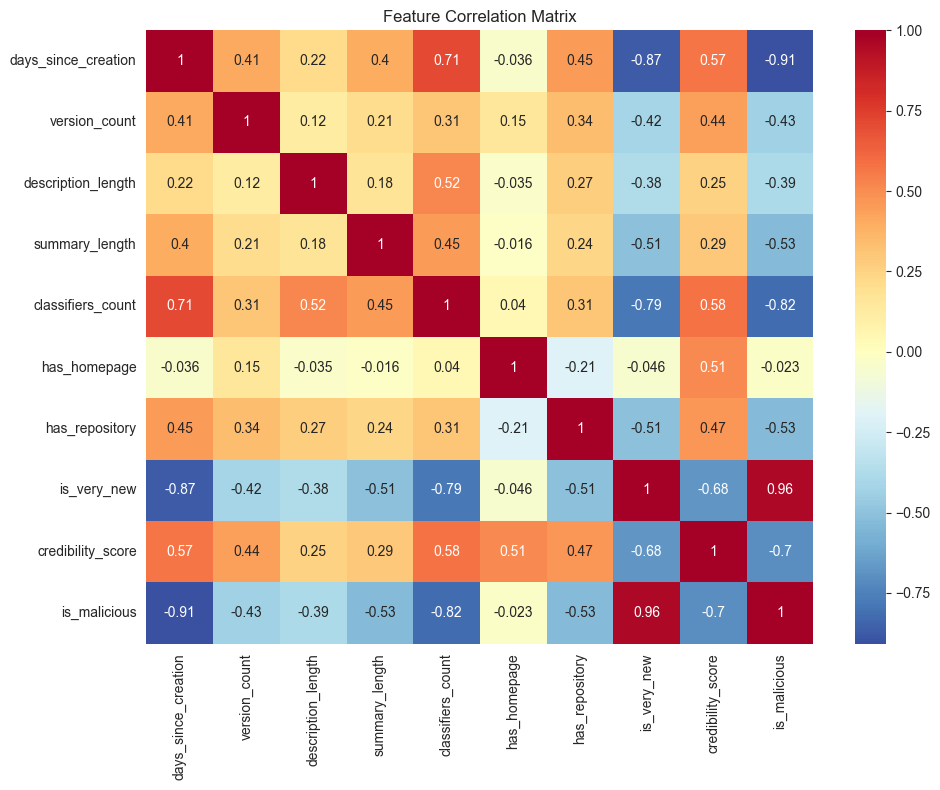

In [6]:
# Correlation matrix for numeric features
numeric_cols = [
    "days_since_creation", "version_count", "description_length",
    "summary_length", "classifiers_count", "has_homepage", "has_repository",
    "is_very_new", "credibility_score", "is_malicious"
]

corr_matrix = df_features[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlBu_r", center=0)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("data/correlation_matrix.png", dpi=150)
plt.show()

## 4. Select Final Features

In [7]:
# Select features for the ML model
FEATURE_COLUMNS = [
    "days_since_creation",
    "version_count",
    "has_homepage",
    "has_repository",
    "description_length",
    "classifiers_count",
    "is_very_new",
    "is_established",
    "is_few_versions",
    "doc_score",
    "credibility_score",
]

TARGET_COLUMN = "is_malicious"

X = df_features[FEATURE_COLUMNS]
y = df_features[TARGET_COLUMN]

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Feature matrix shape: (100, 11)
Target distribution:
is_malicious
0    50
1    50
Name: count, dtype: int64


In [8]:
# Save processed data
X.to_csv("data/features.csv", index=False)
y.to_csv("data/labels.csv", index=False)

# Save feature column names for later use
import json
with open("data/feature_columns.json", "w") as f:
    json.dump(FEATURE_COLUMNS, f)

print("Saved processed features to data/")

Saved processed features to data/


## Next Steps

Open `03_model_training.ipynb` to train the ML models.